%% [markdown]<br>
# Bitcoin Backtesting and Trading Strategies<br>
<br>
This notebook covers a complete workflow for a coding test, organized in three parts:<br>
<br>
**Part 1: Kimchi Momentum Strategy Backtesting**  <br>
- Trading rule: When Bitcoin's price on Upbit goes up by X% (signal to long Binance), and down by Y% (signal to short).<br>
- Synthetic data generation for Bitcoin prices on Upbit and Binance.<br>
- Data splitting into backtesting (first 50%) and forward testing (last 50%).<br>
- Looping over a range of X and Y values, performing backtests, and generating a Sharpe ratio heat map.<br>
- Calculation of CAGR, Maximum Drawdown, and Sharpe Ratio.<br>
<br>
**Part 2: Alpha Factors Backtesting**  <br>
- Generating synthetic hourly candlestick data for BTCUSDT.<br>
- Computing three alpha factors (alpha_A, alpha_B, and alpha_C) using the formulas provided.<br>
- Creating simple trading signals (e.g., long when the alpha is positive, short otherwise).<br>
- Backtesting the combined strategy based on the computed alphas and visualizing its performance.<br>
<br>
**Part 3: Bonus – Bonus Strategies Brainstorm Backtesting**  <br>
- Proposing a simple CTA (trend-following) strategy using moving averages.<br>
- Backtesting the strategy on the synthetic data.<br>
- Computing key performance metrics and plotting the CTA strategy's equity curve.<br>
<br>
Each section is well documented for clarity.

%%<br>
%% [code]

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scienceplots
# Set visualization style
plt.style.use(['science','ieee'])



We simulate a time series using a random walk model for both exchanges.

In [91]:
np.random.seed(42)
dates = pd.date_range(start="2021-01-01", periods=1000, freq="D")

Simulate Upbit Bitcoin price with a random walk

In [92]:
upbit_returns = np.random.normal(loc=0.0005, scale=0.02, size=len(dates))
upbit_price = 50000 * np.exp(np.cumsum(upbit_returns))  # starting around $50K

Simulate Binance Bitcoin price by using similar returns with extra noise/spread

In [93]:
binance_returns = upbit_returns + np.random.normal(loc=0.0001, scale=0.005, size=len(dates))
binance_price = 50000 * np.exp(np.cumsum(binance_returns))

Create DataFrame

In [94]:
data = pd.DataFrame({"Date": dates, "Upbit": upbit_price, "Binance": binance_price})
data.set_index("Date", inplace=True)
print(data.head())

                   Upbit       Binance
Date                                  
2021-01-01  50524.445501  50884.281561
2021-01-02  50410.122717  51009.502967
2021-01-03  51092.911696  51720.999073
2021-01-04  52699.521213  53180.393432
2021-01-05  52479.535986  53148.922565


%%<br>
%% [code]<br>
Split the data into two equal parts:<br>
- First 50% for backtesting (parameter tuning)<br>
- Last 50% for forward testing

In [95]:
split_index = len(data) // 2
backtest_data = data.iloc[:split_index]
forward_data = data.iloc[split_index:]
print("Backtest period:", backtest_data.index[0].date(), "to", backtest_data.index[-1].date())
print("Forward test period:", forward_data.index[0].date(), "to", forward_data.index[-1].date())

Backtest period: 2021-01-01 to 2022-05-15
Forward test period: 2022-05-16 to 2023-09-27


%%<br>
%% [code]<br>
Define performance metrics functions

In [96]:
def calculate_cagr(equity_curve, periods_per_year=365):
    """
    Compute Compound Annual Growth Rate (CAGR).
    equity_curve: pd.Series representing the equity curve.
    periods_per_year: number of periods per year (365 for daily data).
    """
    n_periods = len(equity_curve)
    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0]
    cagr = total_return ** (periods_per_year / n_periods) - 1
    return cagr

In [97]:
def calculate_max_drawdown(equity_curve):
    """
    Compute the maximum drawdown of the equity curve.
    """
    roll_max = equity_curve.cummax()
    drawdown = (equity_curve - roll_max) / roll_max
    max_drawdown = drawdown.min()
    return max_drawdown

In [98]:
def calculate_sharpe_ratio(returns, risk_free_rate=0, periods_per_year=365):
    """
    Compute the Sharpe Ratio.
    returns: pd.Series of periodic returns.
    risk_free_rate: annual risk-free rate.
    periods_per_year: number of periods per year (365 for daily data).
    """
    excess_returns = returns - risk_free_rate/periods_per_year
    sharpe = np.sqrt(periods_per_year) * (excess_returns.mean() / excess_returns.std())
    return sharpe

%%<br>
%% [code]<br>
Backtesting function for the Kimchi Momentum strategy

In [99]:
def backtest_strategy(data, threshold_up, threshold_down):
    """
    Backtest the Kimchi Momentum strategy.
    - If Upbit's daily price increases by at least threshold_up (%), take a long position on Binance.
    - If Upbit's daily price decreases by threshold_down (%), take a short position on Binance.
    
    Parameters:
      data : DataFrame with 'Upbit' and 'Binance' price columns.
      threshold_up : Percentage threshold for a long signal.
      threshold_down : Percentage threshold for a short signal.
    
    Returns:
      returns: Series of daily strategy returns.
      equity_curve: Cumulative product representing the equity curve.
    """
    returns = []
    # Loop over the data starting from the second day
    for i in range(1, len(data)):
        # Calculate the percentage change for Upbit from the previous day
        up_change = (data['Upbit'].iloc[i] - data['Upbit'].iloc[i-1]) / data['Upbit'].iloc[i-1] * 100  
        # Determine position based on thresholds
        if up_change >= threshold_up:
            position = 1    # Long signal
        elif up_change <= -threshold_down:
            position = -1   # Short signal
        else:
            position = 0    # No trade
        
        # Calculate Binance's daily return
        binance_return = (data['Binance'].iloc[i] - data['Binance'].iloc[i-1]) / data['Binance'].iloc[i-1]
        # Strategy daily return based on position
        daily_return = position * binance_return
        returns.append(daily_return)
    
    returns = pd.Series(returns, index=data.index[1:])
    # Build cumulative equity curve assuming starting capital of 1
    equity_curve = (1 + returns).cumprod()
    return returns, equity_curve

%%<br>
%% [code]<br>
Parameter Optimization: Loop over a range of (X, Y) thresholds and compute the Sharpe Ratio.<br>
We use thresholds from 0.5% to 3.0% (in increments of 0.5%).

In [100]:
threshold_vals = np.arange(0.5, 3.5, 0.5)
heatmap_df = pd.DataFrame(index=threshold_vals, columns=threshold_vals)

In [101]:
for X in threshold_vals:
    for Y in threshold_vals:
        ret, eq_curve = backtest_strategy(backtest_data, threshold_up=X, threshold_down=Y)
        sharpe = calculate_sharpe_ratio(ret)
        heatmap_df.loc[X, Y] = sharpe

In [102]:
heatmap_df = heatmap_df.astype(float)

Plot the Sharpe ratio heat map

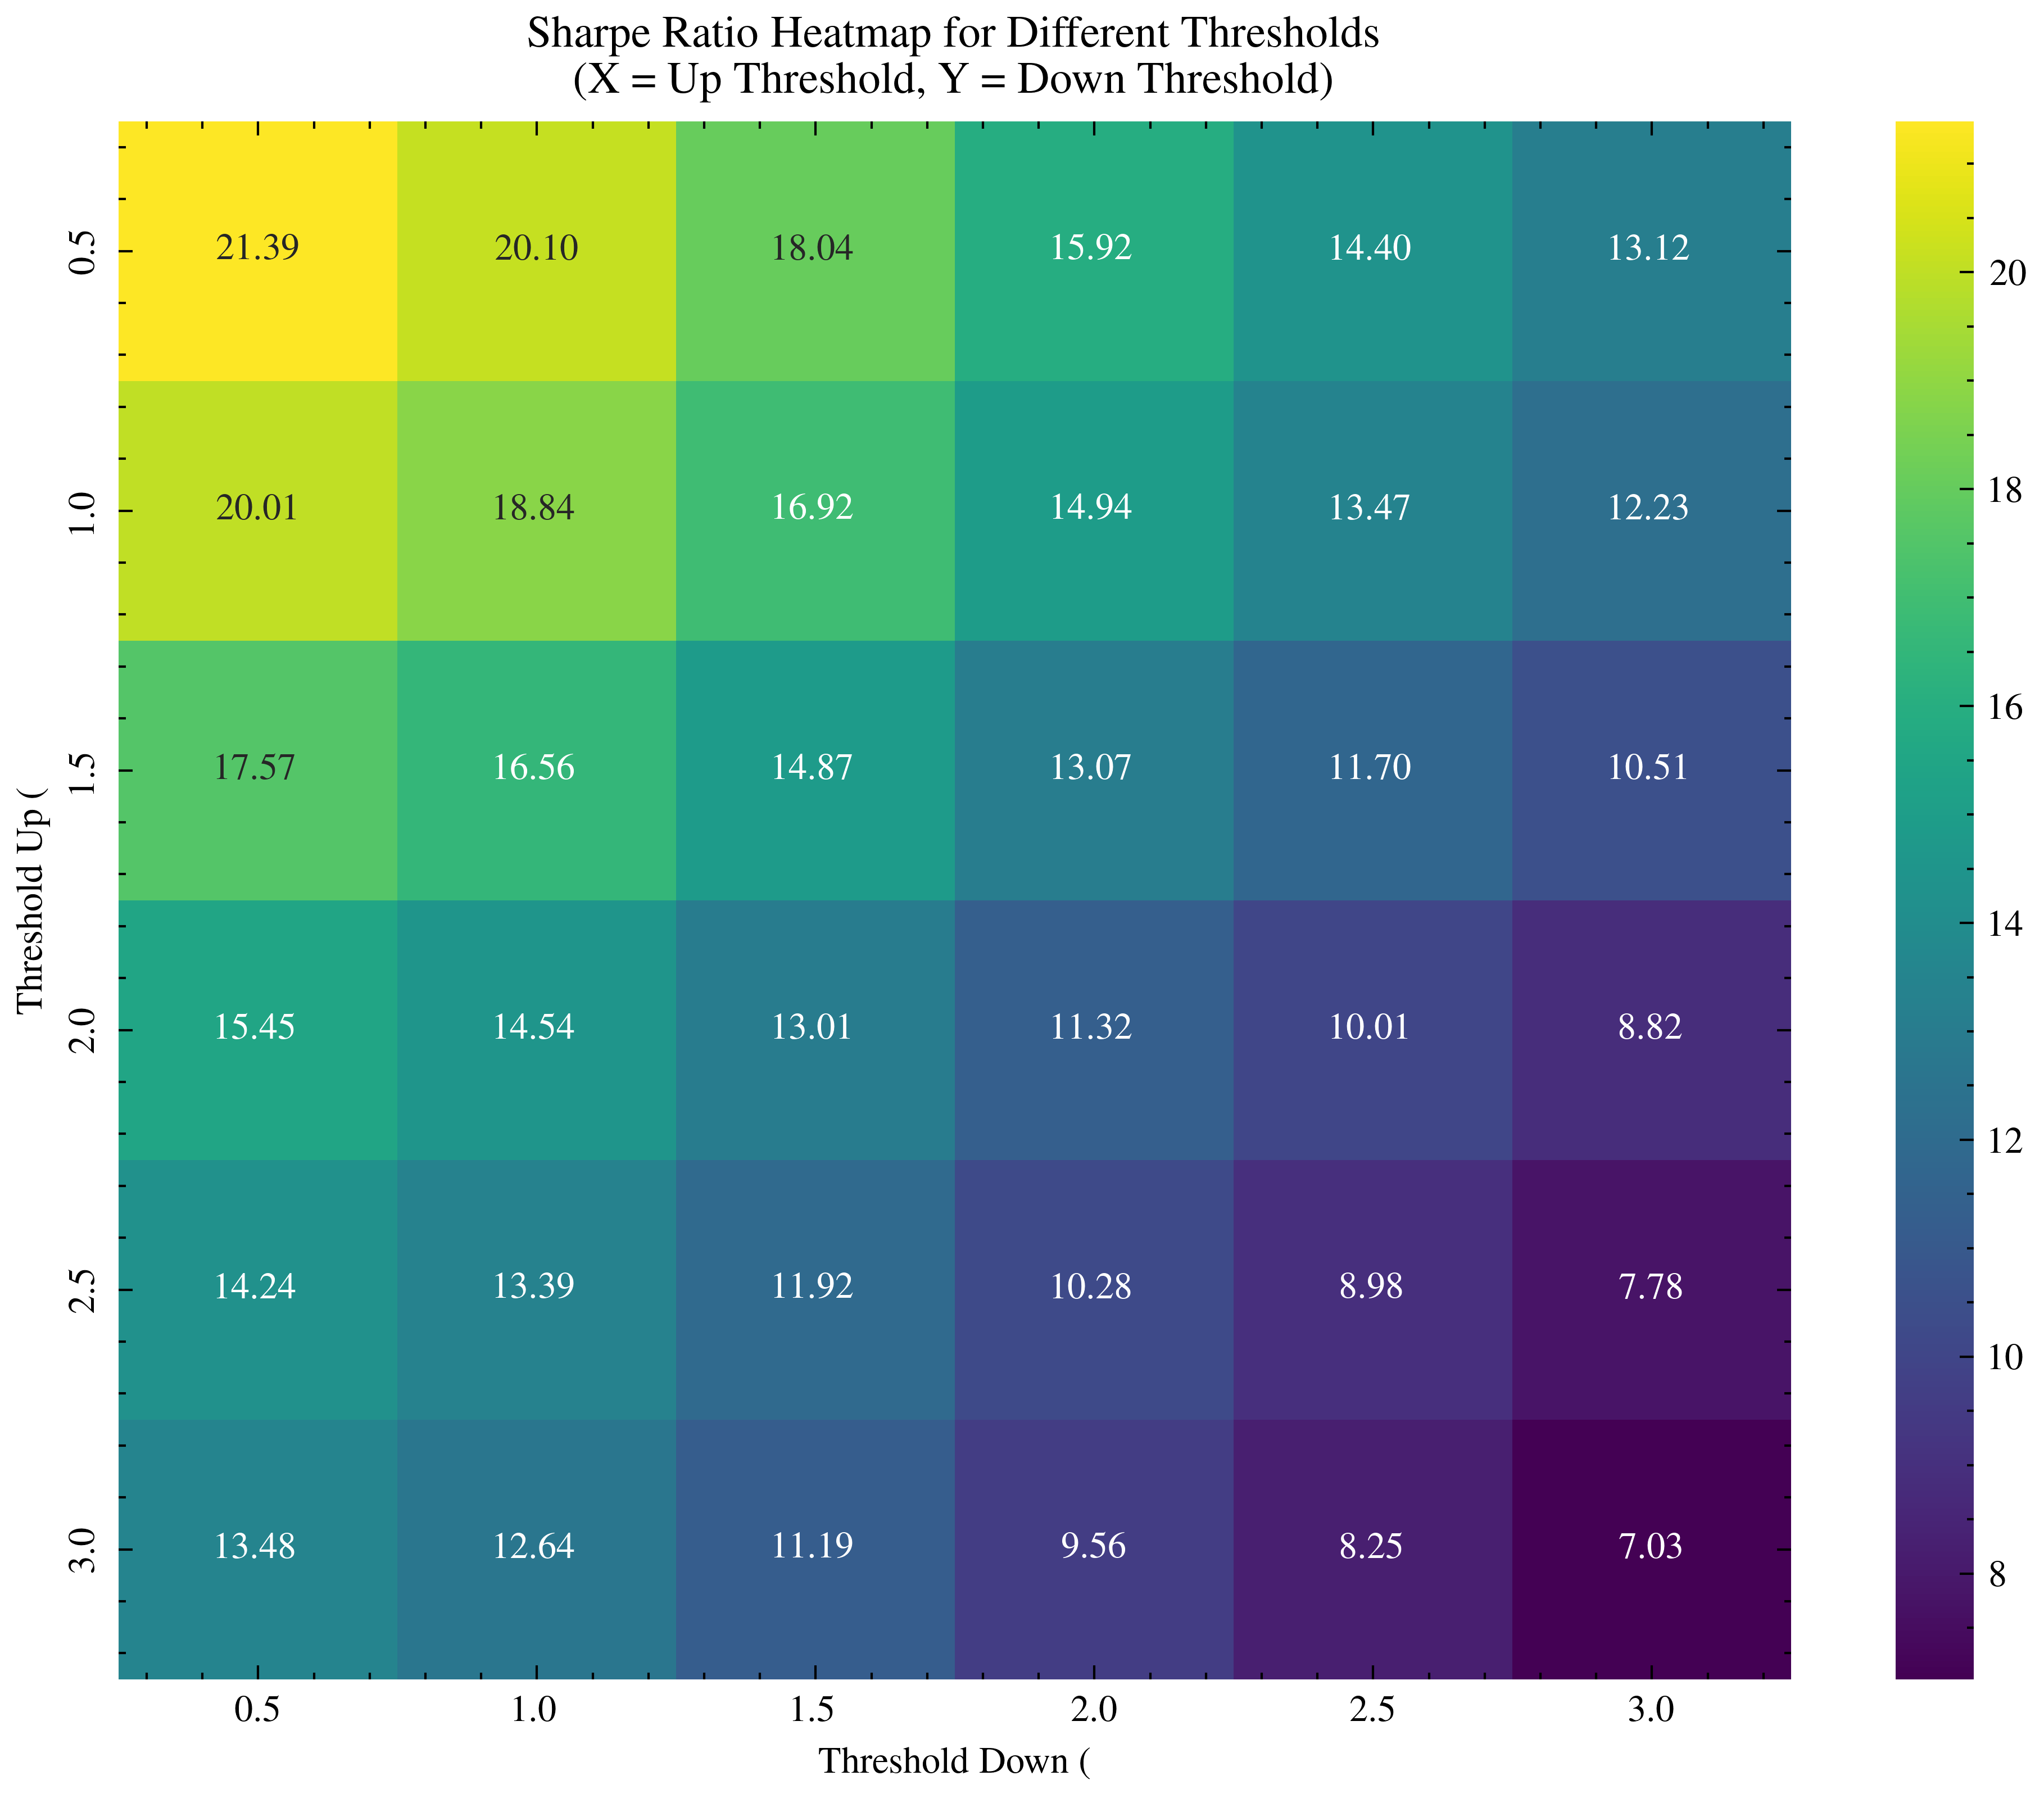

In [103]:
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="viridis")
plt.title("Sharpe Ratio Heatmap for Different Thresholds\n(X = Up Threshold, Y = Down Threshold)")
plt.xlabel("Threshold Down (%)")
plt.ylabel("Threshold Up (%)")
plt.show()

%%<br>
%% [code]<br>
Choose optimal parameters (highest Sharpe ratio) from the heat map.

In [104]:
optimal_params = heatmap_df.stack().idxmax()
optimal_X, optimal_Y = optimal_params  
print("Optimal parameters found: X (up) = {}, Y (down) = {}".format(optimal_X, optimal_Y))

Optimal parameters found: X (up) = 0.5, Y (down) = 0.5


Backtest strategy on the backtesting data using the optimal parameters

In [105]:
opt_ret, opt_eq_curve = backtest_strategy(backtest_data, threshold_up=optimal_X, threshold_down=optimal_Y)

Calculate performance metrics

In [106]:
cagr = calculate_cagr(opt_eq_curve)
max_dd = calculate_max_drawdown(opt_eq_curve)
sharpe = calculate_sharpe_ratio(opt_ret)

In [107]:
print("\nPerformance Metrics on Backtest Data:")
print("CAGR: {:.2%}".format(cagr))
print("Maximum Drawdown: {:.2%}".format(max_dd))
print("Sharpe Ratio: {:.2f}".format(sharpe))


Performance Metrics on Backtest Data:
CAGR: 21204.06%
Maximum Drawdown: -0.42%
Sharpe Ratio: 21.39


Plot the performance (equity) curve

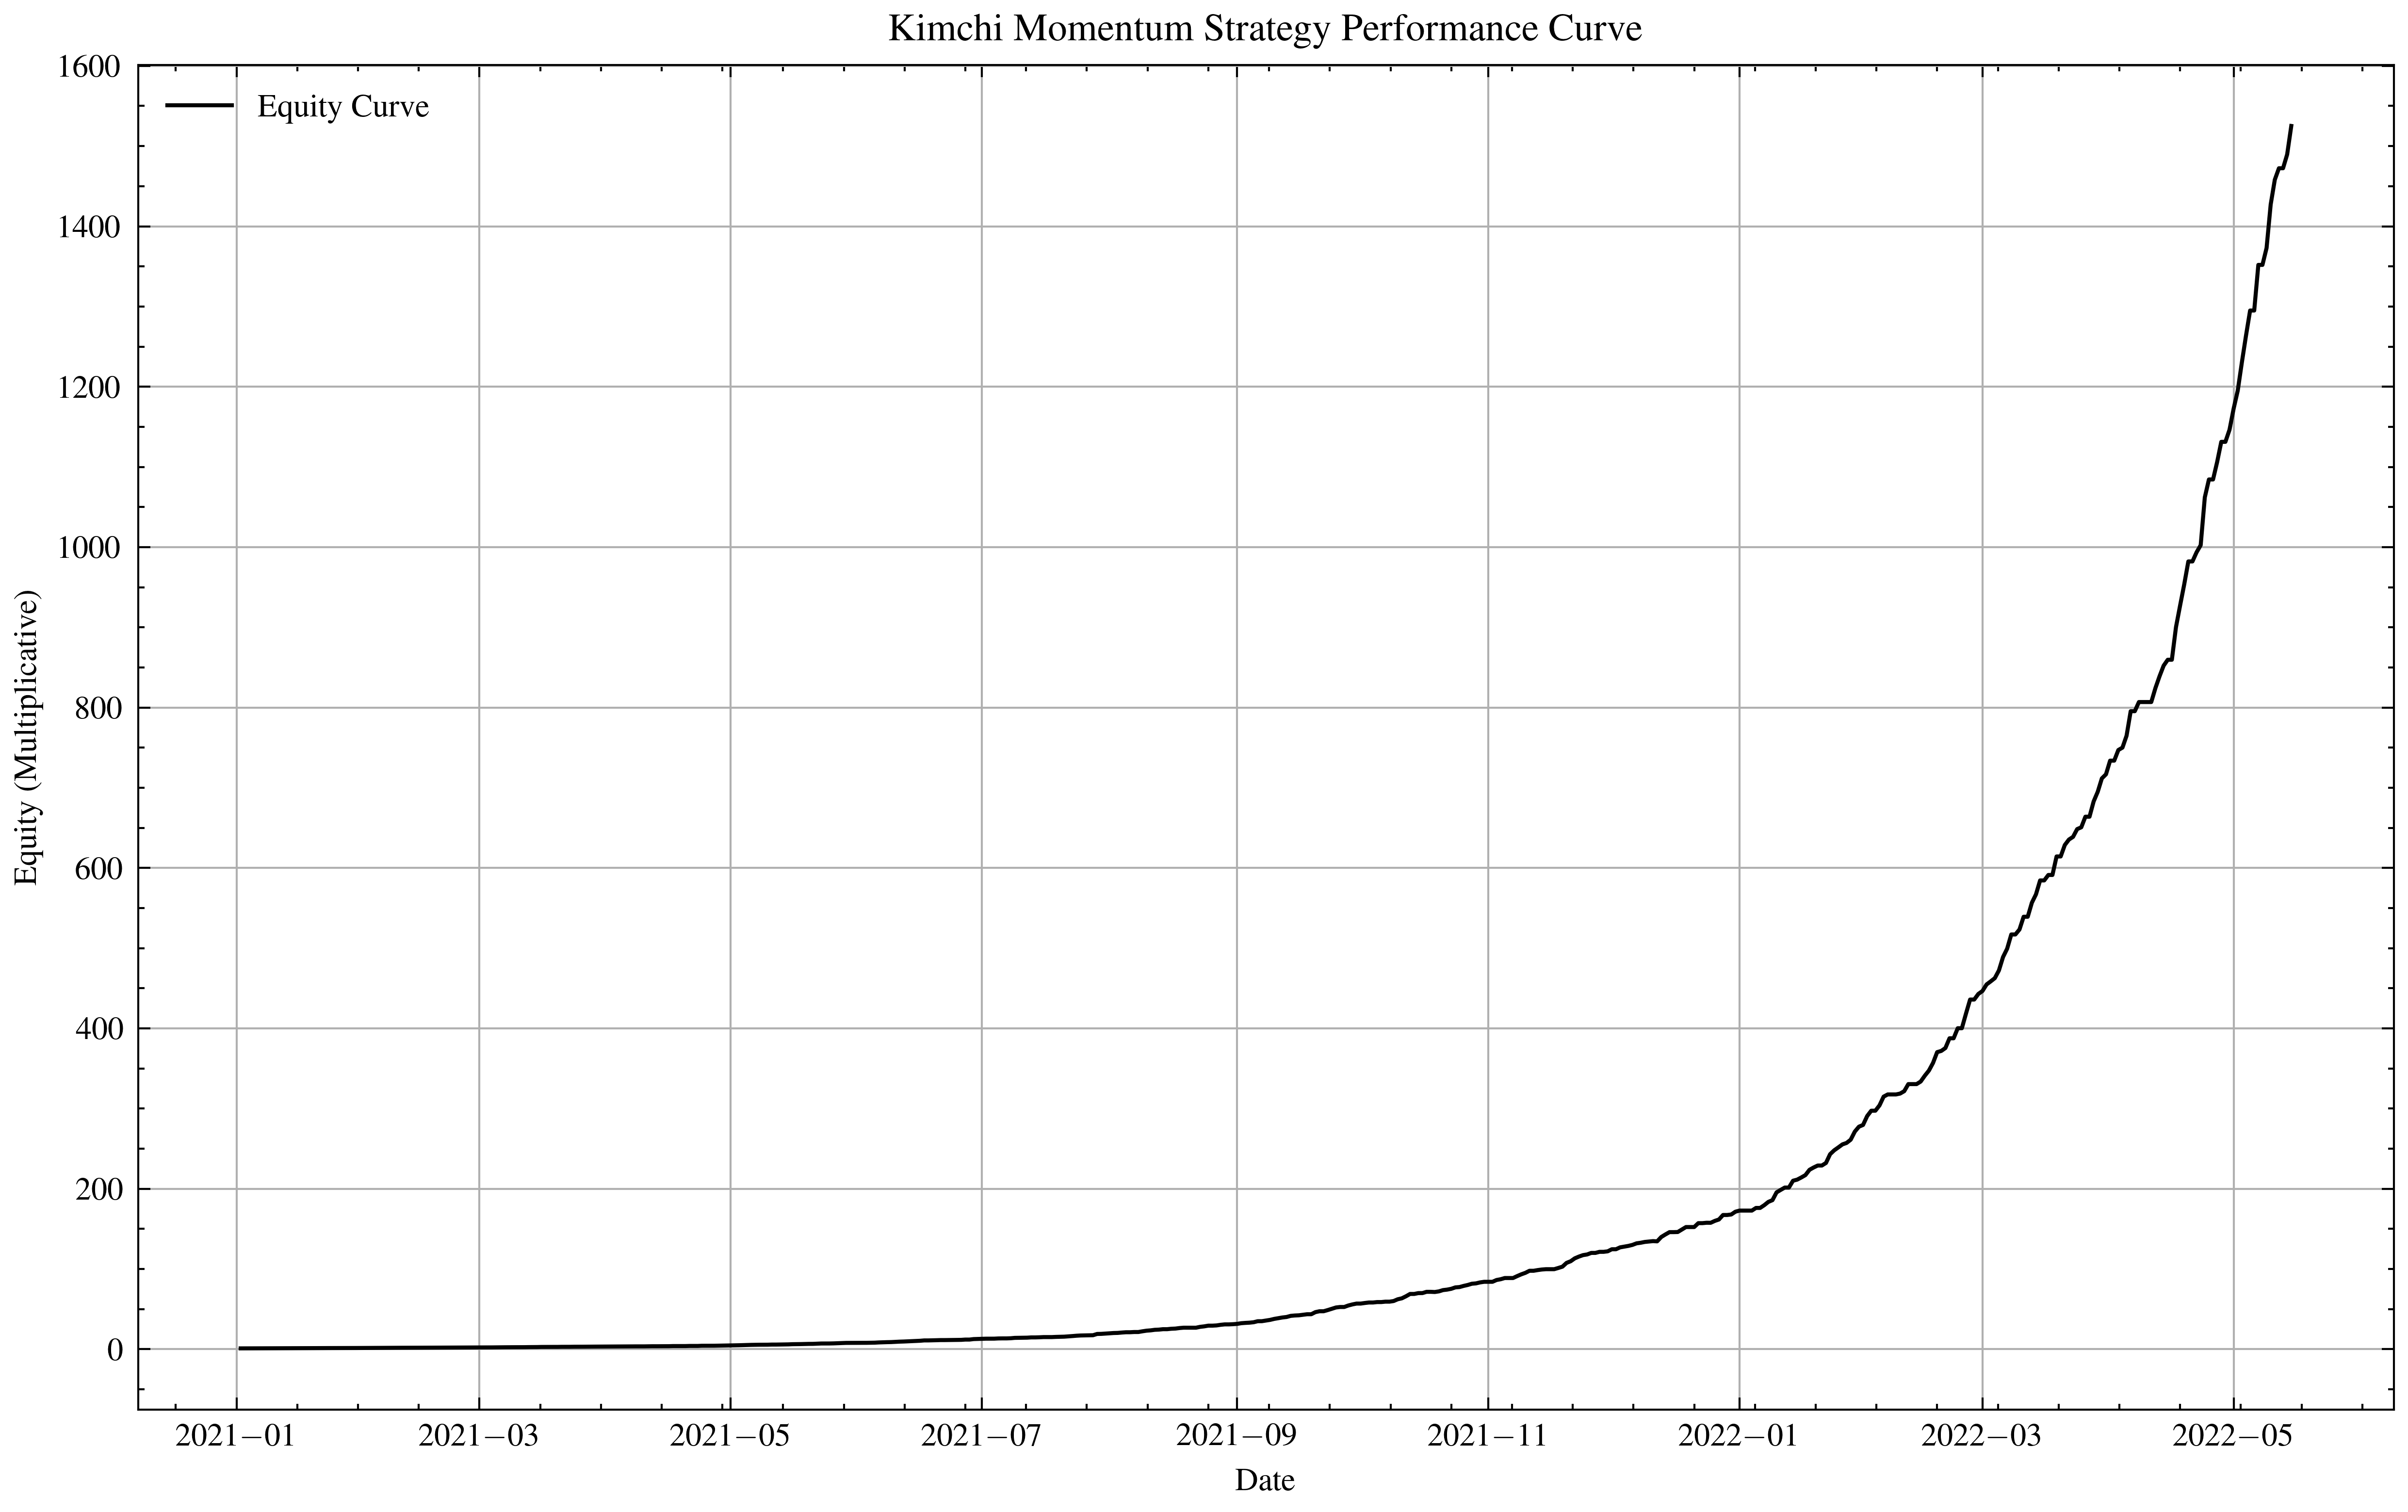

In [108]:
plt.figure(figsize=(10,6))
plt.plot(opt_eq_curve.index, opt_eq_curve, label="Equity Curve")
plt.title("Kimchi Momentum Strategy Performance Curve")
plt.xlabel("Date")
plt.ylabel("Equity (Multiplicative)")
plt.legend()
plt.grid(True)
plt.show()


## Part 2: Alpha Factors Backtesting<br>
<br>
In this section, we simulate synthetic hourly candlestick data for BTCUSDT and compute three alpha factors:<br>
<br>
- **alpha_A:** √(High × Low) − VWAP  <br>
   VWAP is calculated over a 24-hour rolling window using the typical price.<br>
<br>
- **alpha_B:** -1 * ((Low − Close) × (Open⁵)) / ((Low − High) × (Close⁵))  <br>
   A small epsilon value is used to avoid division by zero.<br>
<br>
- **alpha_C:** (Close − Open) / ((High − Low) + 0.001)<br>
<br>
After computing the alphas, a simple trading signal is defined for each (long if the alpha is positive, short otherwise), and the signals are combined.<br>
The strategy is then backtested, and performance metrics plus the equity curve are plotted.


Synthetic Hourly Data Generation for BTCUSDT<br>
---------------------------------------------

In [109]:
dates_hourly = pd.date_range(start="2021-01-01", periods=1000, freq="H")
np.random.seed(42)

/tmp/ipykernel_6416/1259134341.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates_hourly = pd.date_range(start="2021-01-01", periods=1000, freq="H")


Simulate a random walk for price

In [110]:
price = 50000 * np.exp(np.cumsum(np.random.normal(0.0001, 0.01, size=len(dates_hourly))))

Create synthetic OHLC data: we slightly adjust prices to simulate open, high, low, and close

In [111]:
open_prices = price
close_prices = open_prices * (1 + np.random.normal(0.000, 0.005, size=len(price)))
high_prices = np.maximum(open_prices, close_prices) * (1 + np.abs(np.random.normal(0.001, 0.002, size=len(price))))
low_prices = np.minimum(open_prices, close_prices) * (1 - np.abs(np.random.normal(0.001, 0.002, size=len(price))))
volumes = np.random.randint(100, 1000, size=len(price))

Construct the DataFrame

In [112]:
df_alpha = pd.DataFrame({
    "Open": open_prices,
    "High": high_prices,
    "Low": low_prices,
    "Close": close_prices,
    "Volume": volumes
}, index=dates_hourly)

In [113]:
print(df_alpha.head())

                             Open          High           Low         Close  \
2021-01-01 00:00:00  50254.000060  50623.346110  50112.504138  50605.616101   
2021-01-01 01:00:00  50189.583439  50457.466223  50153.408292  50421.618336   
2021-01-01 02:00:00  50520.762446  50565.380669  50512.033017  50535.825305   
2021-01-01 03:00:00  51301.227917  51320.931536  50891.094485  51135.284661   
2021-01-01 04:00:00  51186.363268  51508.227033  51078.201044  51365.060829   

                     Volume  
2021-01-01 00:00:00     662  
2021-01-01 01:00:00     365  
2021-01-01 02:00:00     219  
2021-01-01 03:00:00     811  
2021-01-01 04:00:00     347  


Data Cleaning: Fill missing values if any (for synthetic data, this is precautionary).

In [114]:
df_alpha.fillna(method='ffill', inplace=True)

/tmp/ipykernel_6416/3855716350.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_alpha.fillna(method='ffill', inplace=True)


Compute Alpha Factors<br>
-----------------------<br>
1. alpha_A = sqrt(High * Low) - VWAP, over a rolling 24-hour window.

In [115]:
df_alpha["Typical"] = (df_alpha["Close"] + df_alpha["High"] + df_alpha["Low"]) / 3
window = 24  # 24-hour rolling window
df_alpha["VWAP"] = (df_alpha["Typical"] * df_alpha["Volume"]).rolling(window=window).sum() / df_alpha["Volume"].rolling(window=window).sum()
df_alpha["VWAP"].fillna(method='bfill', inplace=True)
df_alpha["alpha_A"] = np.sqrt(df_alpha["High"] * df_alpha["Low"]) - df_alpha["VWAP"]

/tmp/ipykernel_6416/4221851640.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_alpha["VWAP"].fillna(method='bfill', inplace=True)
/tmp/ipykernel_6416/4221851640.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_alpha["VWAP"].fillna(method='bfill', inplace=True)


2. alpha_B = -1 * ((Low - Close) * (Open^5)) / ((Low - High) * (Close^5))

In [116]:
epsilon = 1e-8  # small value to avoid division by zero
df_alpha["alpha_B"] = -1 * ((df_alpha["Low"] - df_alpha["Close"]) * (df_alpha["Open"]**5)) / (((df_alpha["Low"] - df_alpha["High"]).replace(0, epsilon)) * (df_alpha["Close"]**5 + epsilon))

3. alpha_C = (Close - Open) / ((High - Low) + 0.001)

In [117]:
df_alpha["alpha_C"] = (df_alpha["Close"] - df_alpha["Open"]) / ((df_alpha["High"] - df_alpha["Low"]) + 0.001)

In [118]:
print(df_alpha[["alpha_A", "alpha_B", "alpha_C"]].head(10))

                         alpha_A   alpha_B   alpha_C
2021-01-01 00:00:00  -162.255270 -0.932220  0.688306
2021-01-01 01:00:00  -224.325225 -0.861991  0.763125
2021-01-01 02:00:00     9.167047 -0.445321  0.282348
2021-01-01 03:00:00   576.028348 -0.577377 -0.386060
2021-01-01 04:00:00   763.230629 -0.655552  0.415550
2021-01-01 05:00:00   586.138921 -0.710924  0.388221
2021-01-01 06:00:00  1451.081520 -0.845836  0.600401
2021-01-01 07:00:00  1810.015132 -0.878258  0.537673
2021-01-01 08:00:00  1639.717189 -0.762842  0.488445
2021-01-01 09:00:00  1817.532002 -0.010407 -0.477128


Create Trading Signals based on the computed alphas.<br>
For simplicity, we use:<br>
   - Signal = +1 (Long) if alpha > 0; -1 (Short) if alpha < 0.

In [119]:
df_alpha["signal_A"] = np.where(df_alpha["alpha_A"] > 0, 1, -1)
df_alpha["signal_B"] = np.where(df_alpha["alpha_B"] > 0, 1, -1)
df_alpha["signal_C"] = np.where(df_alpha["alpha_C"] > 0, 1, -1)

Combine signals by averaging (alternative approaches can be used)

In [120]:
df_alpha["combined_signal"] = (df_alpha["signal_A"] + df_alpha["signal_B"] + df_alpha["signal_C"]) / 3
# Final signal: take long if non-negative, else short
df_alpha["combined_signal"] = np.where(df_alpha["combined_signal"] >= 0, 1, -1)

In [121]:
print(df_alpha[["signal_A", "signal_B", "signal_C", "combined_signal"]].tail())

                     signal_A  signal_B  signal_C  combined_signal
2021-02-11 11:00:00        -1        -1         1               -1
2021-02-11 12:00:00        -1        -1        -1               -1
2021-02-11 13:00:00        -1        -1        -1               -1
2021-02-11 14:00:00        -1        -1        -1               -1
2021-02-11 15:00:00        -1        -1        -1               -1


Backtesting the Alpha Factors based Strategy

In [122]:
def backtest_alpha_strategy(df, signal_column="combined_signal"):
    """
    Backtest an alpha factors-based trading strategy on hourly data.
    The strategy returns are computed as the product of the previous period's signal and the current period's return.
    """
    df = df.copy()
    # Calculate hourly returns based on Close price
    df["returns"] = df["Close"].pct_change()
    # Shift signal by one to avoid lookahead bias
    df["strategy_returns"] = df[signal_column].shift(1) * df["returns"]
    # Compute cumulative returns (equity curve)
    df["strategy_equity"] = (1 + df["strategy_returns"].fillna(0)).cumprod()
    return df["strategy_returns"].dropna(), df["strategy_equity"]

In [123]:
alpha_returns, alpha_equity_curve = backtest_alpha_strategy(df_alpha, signal_column="combined_signal")

Use 24*365 as periods per year since the data is hourly.

In [124]:
alpha_cagr = calculate_cagr(alpha_equity_curve, periods_per_year=24*365)
alpha_dd = calculate_max_drawdown(alpha_equity_curve)
alpha_sharpe = calculate_sharpe_ratio(alpha_returns, periods_per_year=24*365)

In [125]:
print("\nAlpha Strategy Performance Metrics:")
print("CAGR: {:.2%}".format(alpha_cagr))
print("Maximum Drawdown: {:.2%}".format(alpha_dd))
print("Sharpe Ratio: {:.2f}".format(alpha_sharpe))


Alpha Strategy Performance Metrics:
CAGR: -100.00%
Maximum Drawdown: -93.27%
Sharpe Ratio: -19.36


Plot the Alpha strategy equity curve

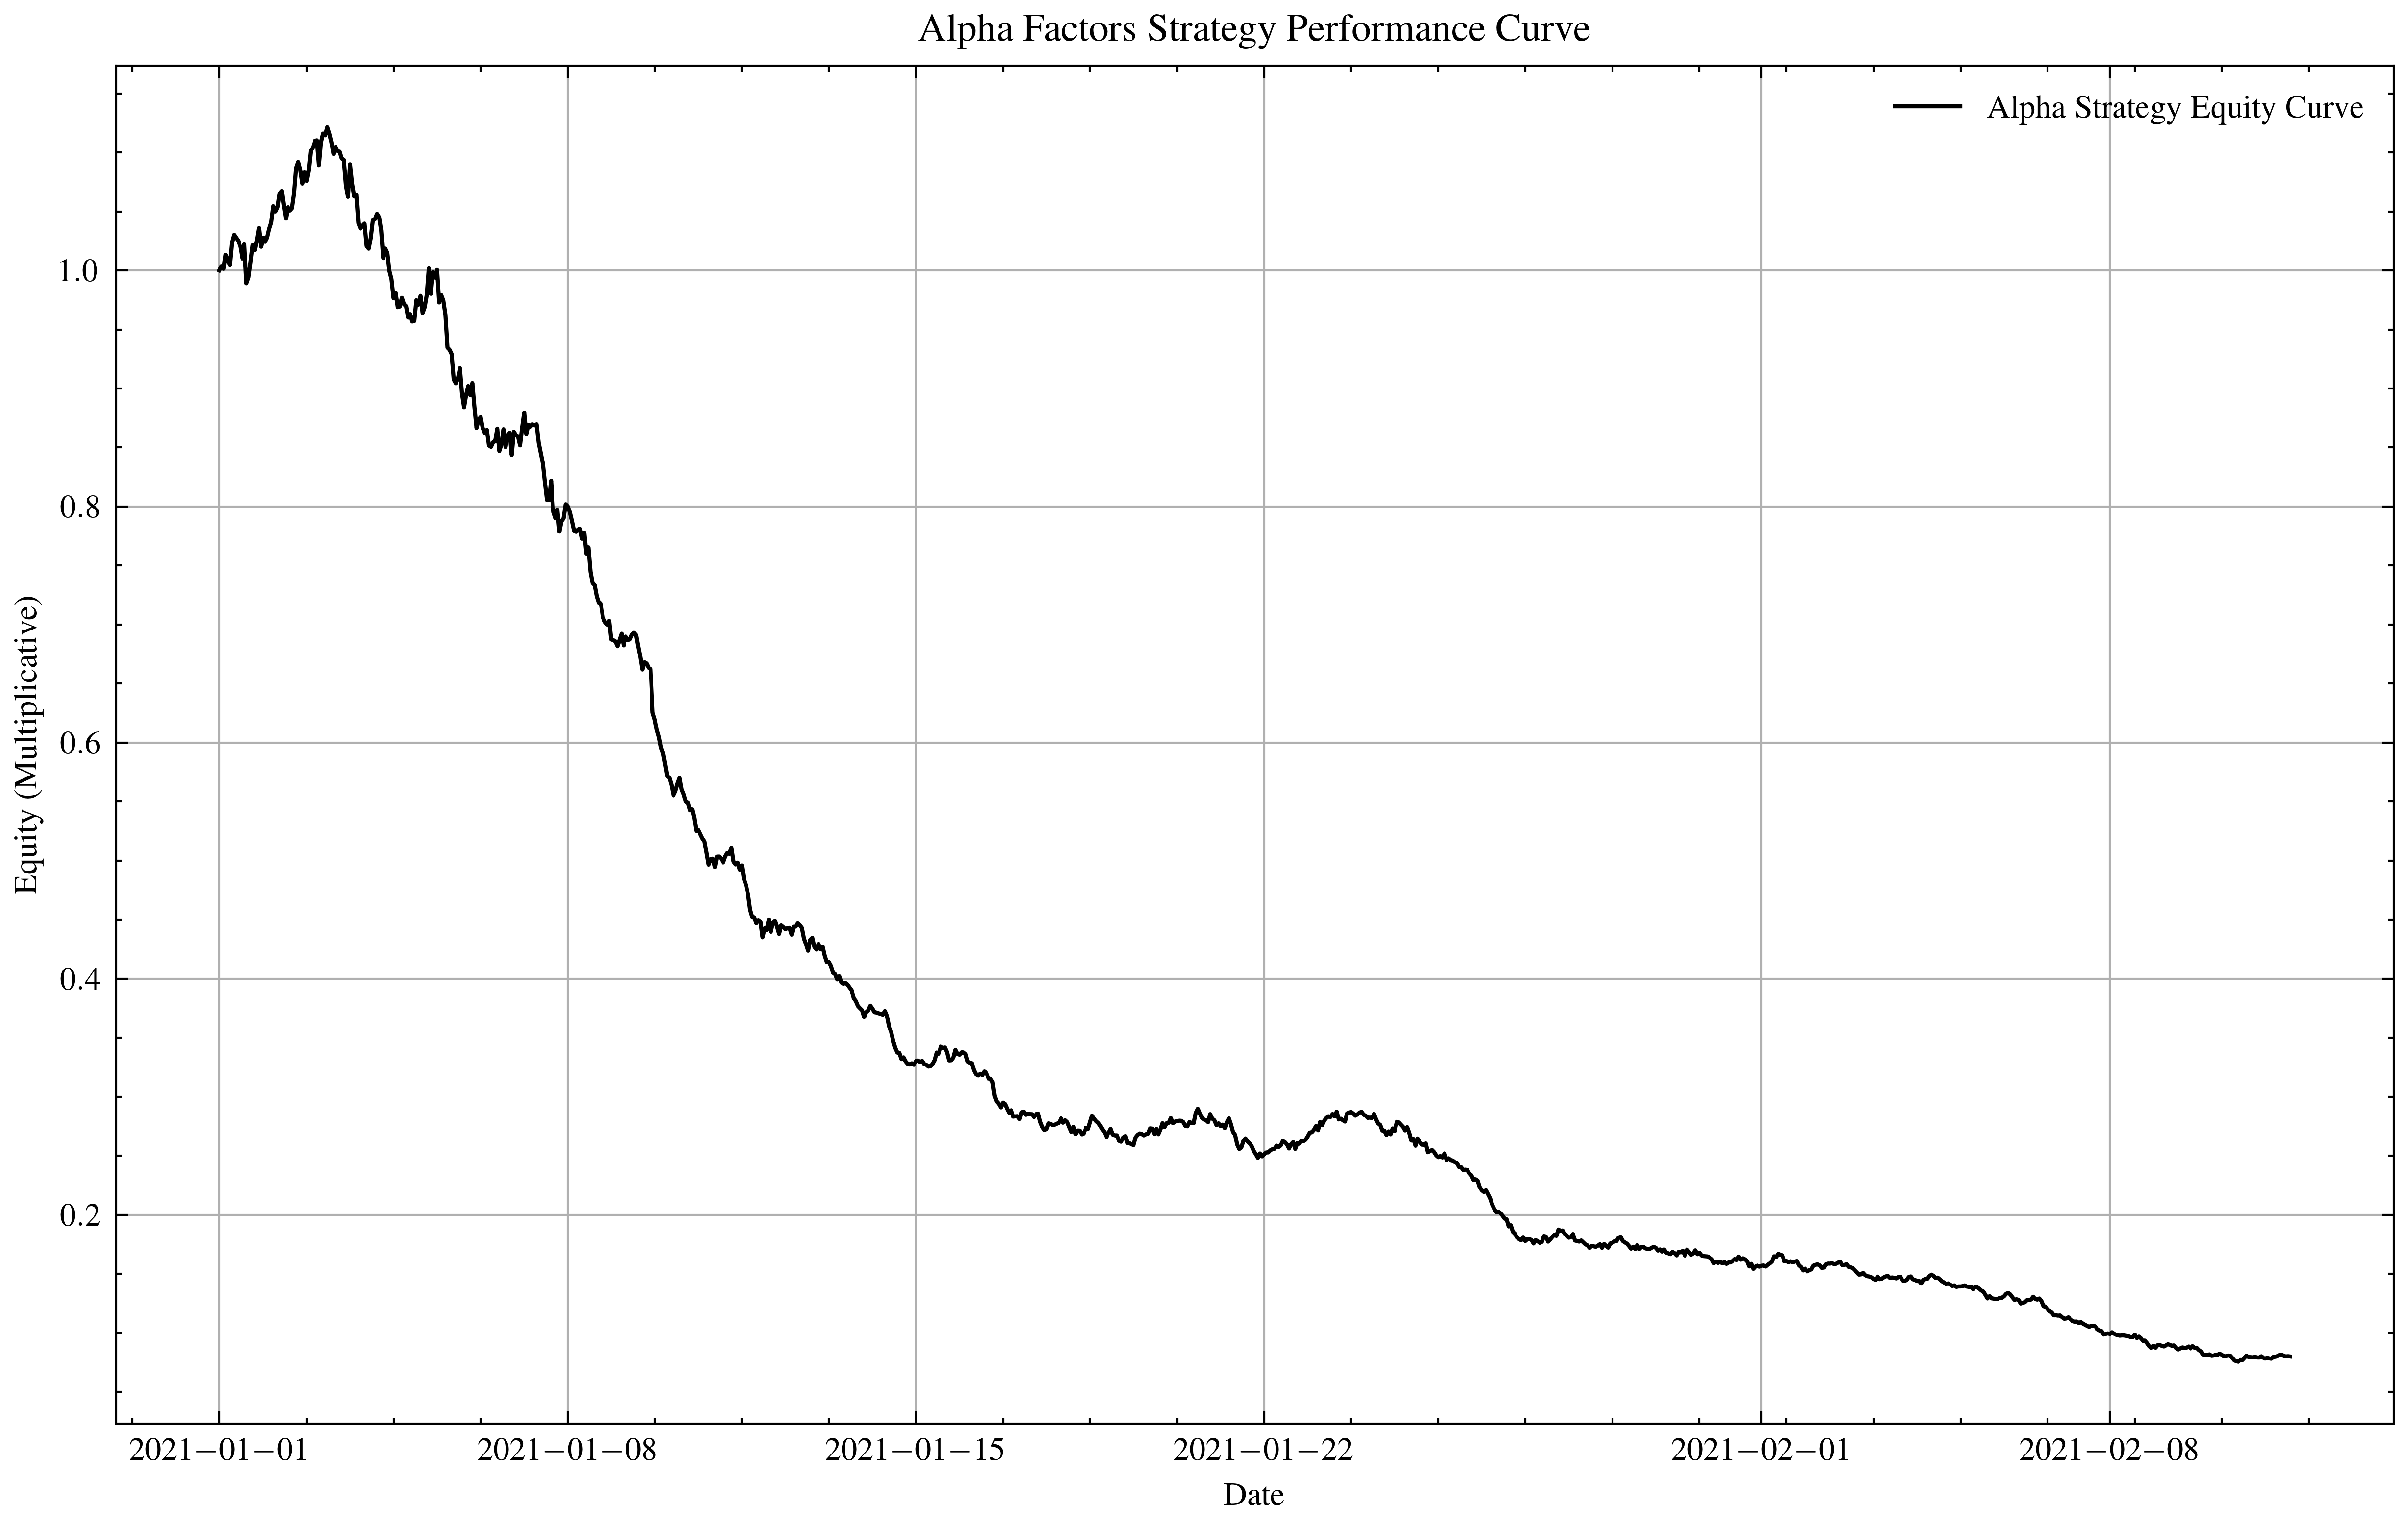

In [126]:
plt.figure(figsize=(10,6))
plt.plot(alpha_equity_curve.index, alpha_equity_curve, label="Alpha Strategy Equity Curve")
plt.title("Alpha Factors Strategy Performance Curve")
plt.xlabel("Date")
plt.ylabel("Equity (Multiplicative)")
plt.legend()
plt.grid(True)
plt.show()

## Part 3: Bonus – Bonus Strategies Brainstorm Backtesting<br>
Here we propose an additional trading strategy using a CTA (trend-following) approach. In this example,<br>
a simple moving average crossover strategy is implemented as follows:<br>
<br>
    1. CTA Strategy (Moving Averages)  <br>
    2. Calculate a short-term moving average (e.g., 24-hour) and a long-term moving average (e.g., 72-hour).<br>
    3. Generate a long signal when the short-term moving average is above the long-term moving average, and vice versa.<br>
<br>
The strategy's performance is backtested with performance metrics computed and the equity curve plotted.<br>
Commentary is provided on the result relative to expectations.

In [127]:
df_bonus = df_alpha.copy()  # Re-use our synthetic hourly data

Calculate short-term and long-term moving averages on the Close price.

In [128]:
df_bonus["MA_short"] = df_bonus["Close"].rolling(window=24).mean()   # 24-hour MA
df_bonus["MA_long"] = df_bonus["Close"].rolling(window=72).mean()    # 72-hour MA

Generate CTA signal: +1 when MA_short > MA_long, else -1.

In [129]:
df_bonus["cta_signal"] = np.where(df_bonus["MA_short"] > df_bonus["MA_long"], 1, -1)

Backtest the CTA strategy: use the CTA signal to weight the hourly returns.

In [130]:
df_bonus["cta_returns"] = df_bonus["cta_signal"].shift(1) * df_bonus["Close"].pct_change()
df_bonus["cta_equity"] = (1 + df_bonus["cta_returns"].fillna(0)).cumprod()

Calculate performance metrics (using hourly periods as before)

In [131]:
cta_cagr = calculate_cagr(df_bonus["cta_equity"], periods_per_year=24*365)
cta_dd = calculate_max_drawdown(df_bonus["cta_equity"])
cta_sharpe = calculate_sharpe_ratio(df_bonus["cta_returns"].dropna(), periods_per_year=24*365)

In [132]:
print("\nCTA Bonus Strategy Performance Metrics:")
print("CAGR: {:.2%}".format(cta_cagr))
print("Maximum Drawdown: {:.2%}".format(cta_dd))
print("Sharpe Ratio: {:.2f}".format(cta_sharpe))


CTA Bonus Strategy Performance Metrics:
CAGR: 1999.70%
Maximum Drawdown: -24.19%
Sharpe Ratio: 3.25


Plot the CTA strategy equity curve

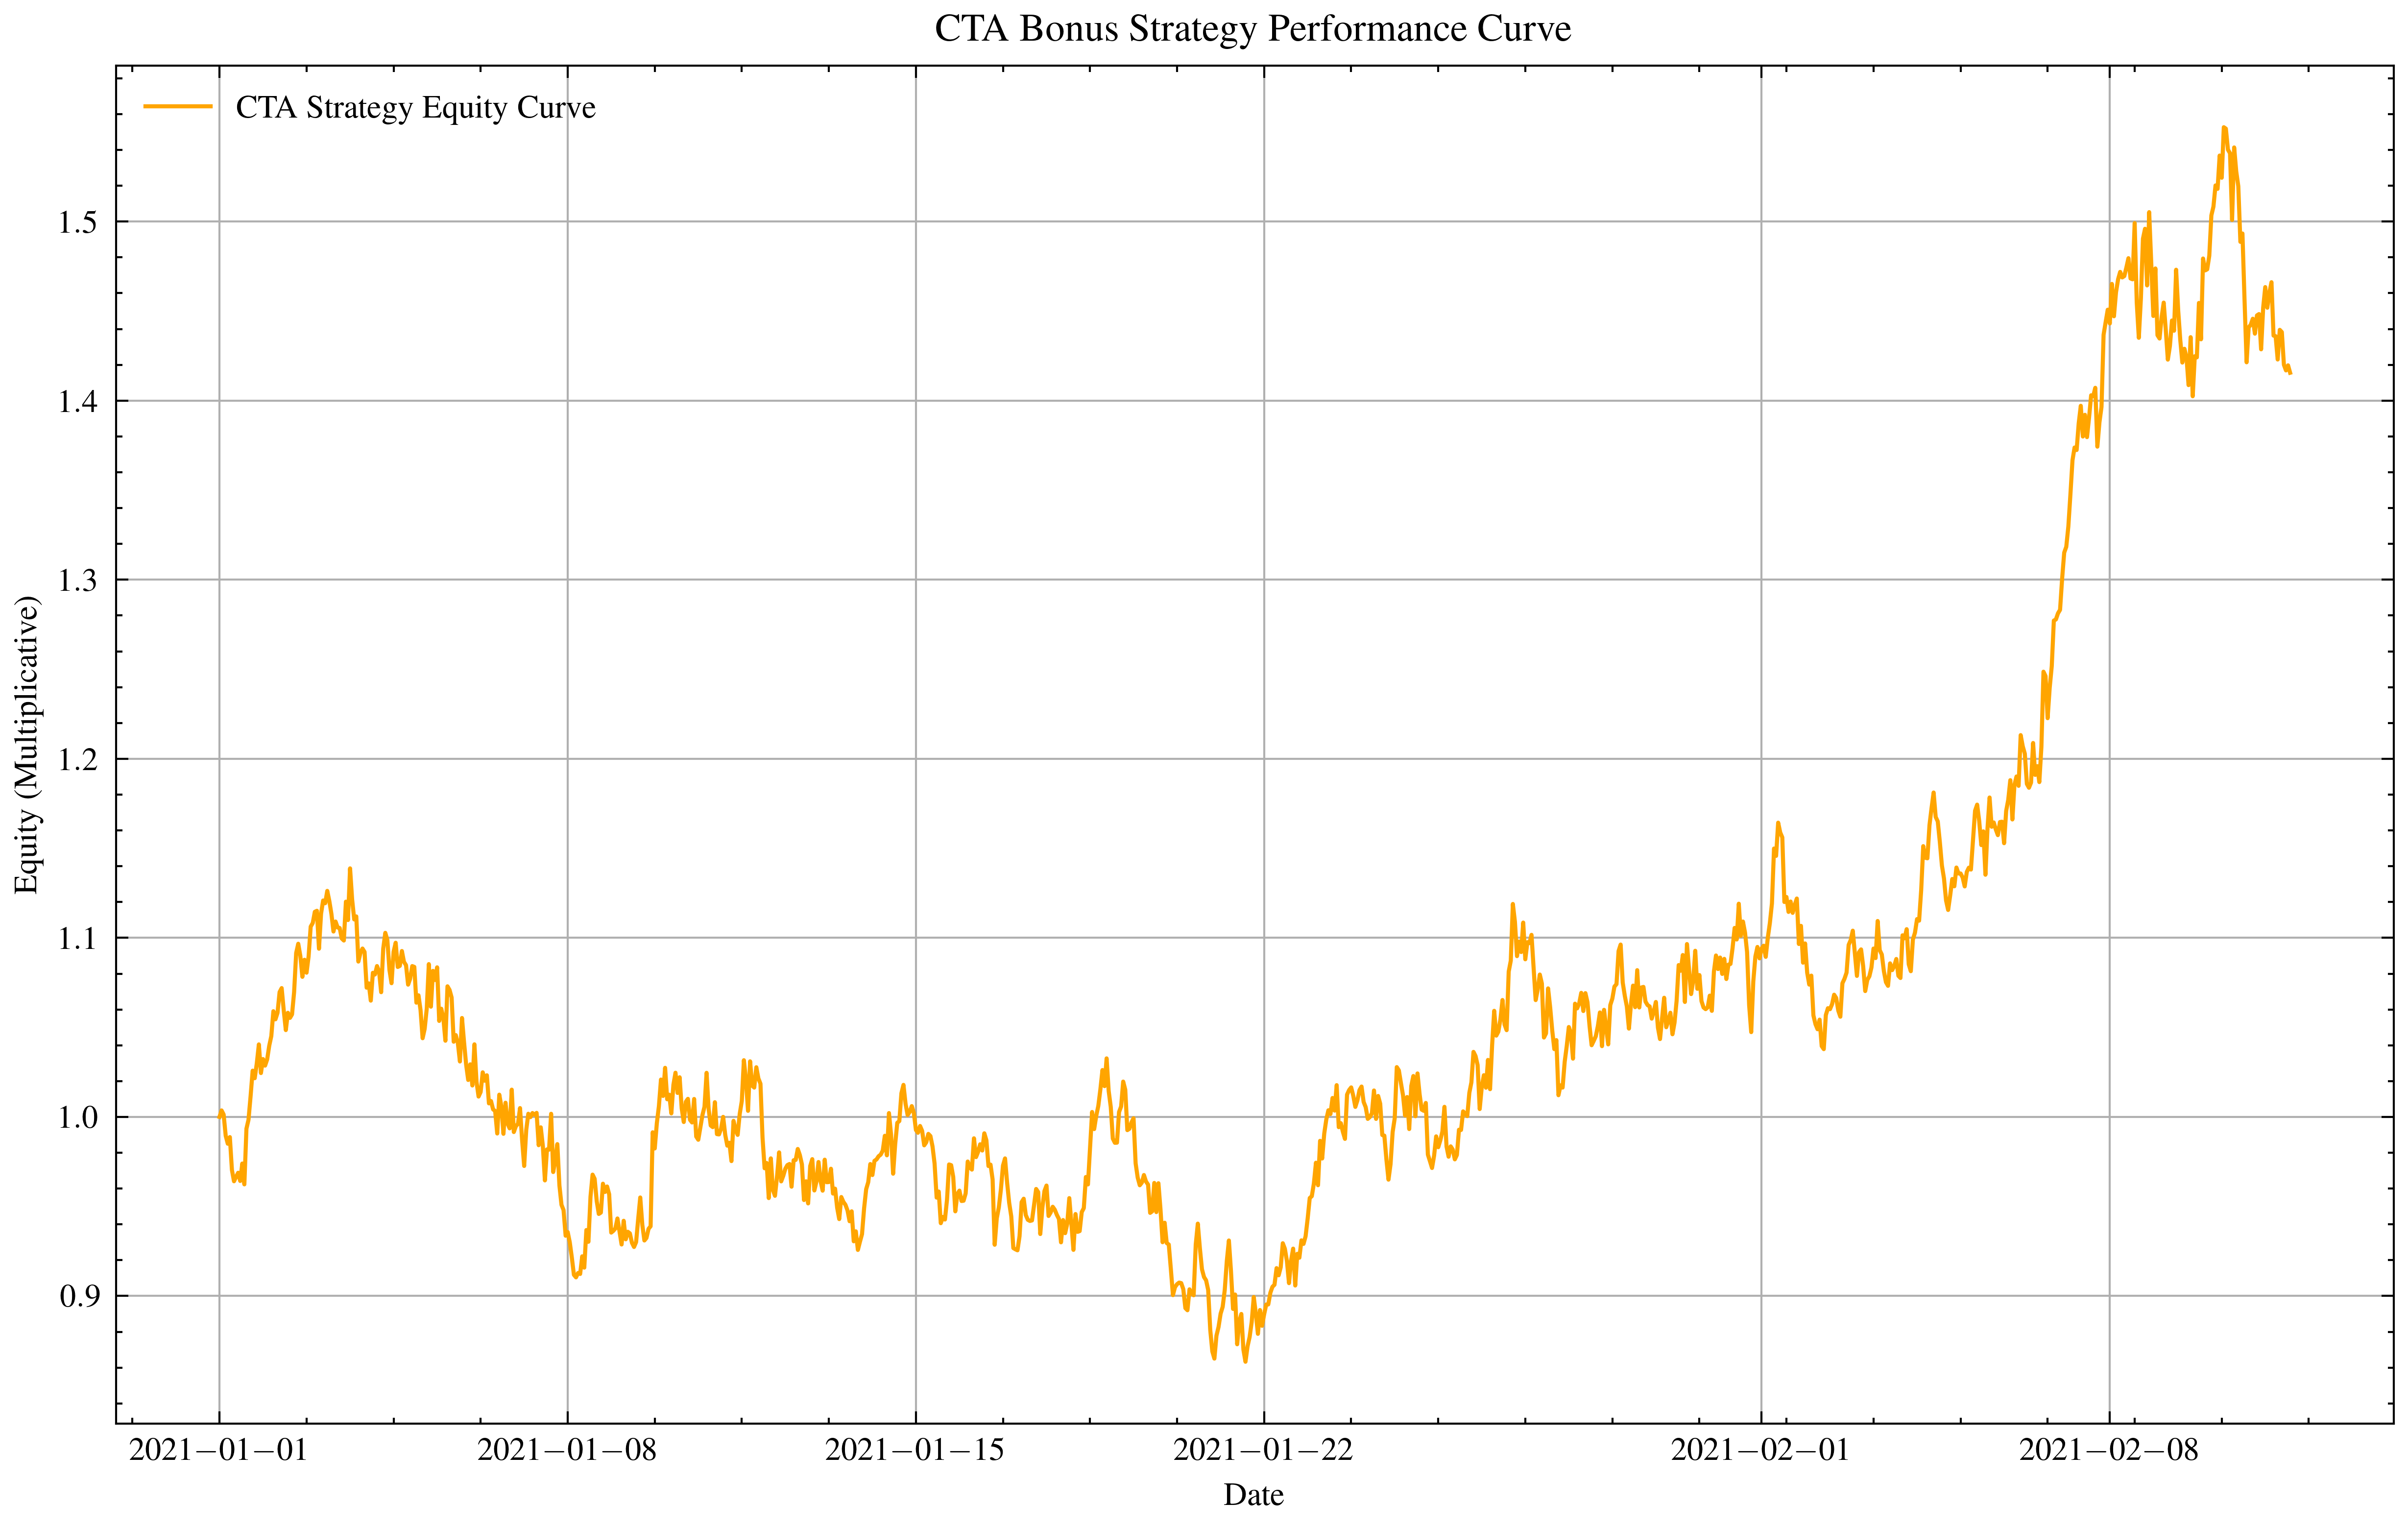

In [133]:
plt.figure(figsize=(10,6))
plt.plot(df_bonus["cta_equity"].index, df_bonus["cta_equity"], label="CTA Strategy Equity Curve", color='orange')
plt.title("CTA Bonus Strategy Performance Curve")
plt.xlabel("Date")
plt.ylabel("Equity (Multiplicative)")
plt.legend()
plt.grid(True)
plt.show()